### Customer Segmentation via K-Means & Hierarchical Clustering & DBSCAN

Customer segmentation is the process of dividing a customer base into smaller groups based on common characteristics or behaviors. This is often done as a way to better understand and target specific segments of a customer base, in order to tailor marketing efforts or product offerings to their specific needs and preferences.

Unsupervised learning is a type of machine learning that involves training a model to find patterns or relationships in data without the use of labeled examples or prior knowledge. It is often used for tasks such as clustering, where the goal is to group data points into clusters based on their similarity to one another. There are several unsupervised learning algorithms that can be used for customer segmentation, including:

K-means clustering: This algorithm divides the data into a specified number of clusters based on the distance between the data points and their respective cluster centroids.

Hierarchical clustering: This algorithm creates a hierarchy of clusters by repeatedly merging or splitting the data based on their similarity.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise): This algorithm divides the data into clusters based on the density of the points and the distance between them.

### Business Problem: Segmentation of a Customer Portfolio

FLO wants to segment its customers and determine marketing strategies according to these segments. To this end, the behaviors of the customers will be defined and groups will be formed according to the clusters in these behaviors

## Dataset Story: Purchasing Behavior of FLO Customers

The dataset includes Flo's last purchases from OmniChannel (both online and offline shoppers) in 2020 - 2021. 12 Variables 19,945 Observations 


master_id: Unique client number

order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)

last_order_channel: The channel where the last purchase was made

first_order_date: The date of the first purchase made by the customer

last_order_date: The date of the customer's last purchase

last_order_date_online: The date of the last purchase made by the customer on the online platform

last_order_date_offline: The date of the last purchase made by the customer on the offline platform

order_num_total_ever_online: The total number of purchases made by the customer on the online platform

order_num_total_ever_offline: Total number of purchases made by the customer offline

customer_value_total_ever_offline: The total price paid by the customer for offline purchases

customer_value_total_ever_online: The total price paid by the customer for their online shopping

interested_in_categories_12: List of categories the customer has purchased from in the last 12 months

## 1. Loading required libraries and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans      # K-Means
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer     # Elbow method 
from scipy.cluster.hierarchy import linkage, dendrogram  # hierarchical clustering
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering     # hierarchical clustering

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import warnings 
warnings.simplefilter(action='ignore', category=Warning)


In [2]:
df = pd.read_csv("flo_data_20k.csv")

In [3]:
df.head(5)

master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                          4.0                           1.0                             139.99                            799.38                           [KADIN]
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                         19.0                           2.0                             159.97                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App       2019-11-27      2020-11-27             2020-11-27              2019-12-01                          3.0                           2.0                             189.97                            395.35                    [ERKEK, KADIN]
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App       2021-01-06      2021-01-17             2021-01-17              2021-01-06                          1.0                           1.0                              39.99                             81.98               [AKTIFCOCUK, COCUK]
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop       2019-08-03      2021-03-07             2021-03-07              2019-08-03                          1.0                           1.0                              49.99                            159.99                       [AKTIFSPOR]

In [4]:
df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 18)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
tenure                                 int64
recency                                int64
frequency                            float64
monetary                             float64
order_num_total                      float64
customer_value_total                 float64
dtype: object
##################### Head #####################
               

## EXPLORATORY DATA ANALYSIS

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [7]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
     # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(cat_cols)
print(num_cols)
print(cat_but_car)

['order_channel', 'last_order_channel']
['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'tenure', 'recency', 'frequency', 'monetary', 'order_num_total', 'customer_value_total']
['master_id', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'interested_in_categories_12']


count    19945.000000
mean         3.110855
std          4.225647
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%          7.000000
95%         10.000000
99%         20.000000
max        200.000000
Name: order_num_total_ever_online, dtype: float64


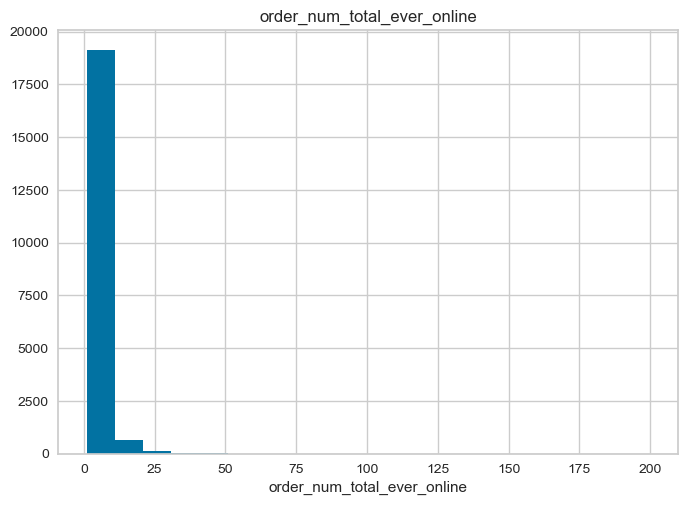

count    19945.000000
mean         1.913913
std          2.062880
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          2.000000
70%          2.000000
80%          3.000000
90%          4.000000
95%          4.000000
99%          7.000000
max        109.000000
Name: order_num_total_ever_offline, dtype: float64


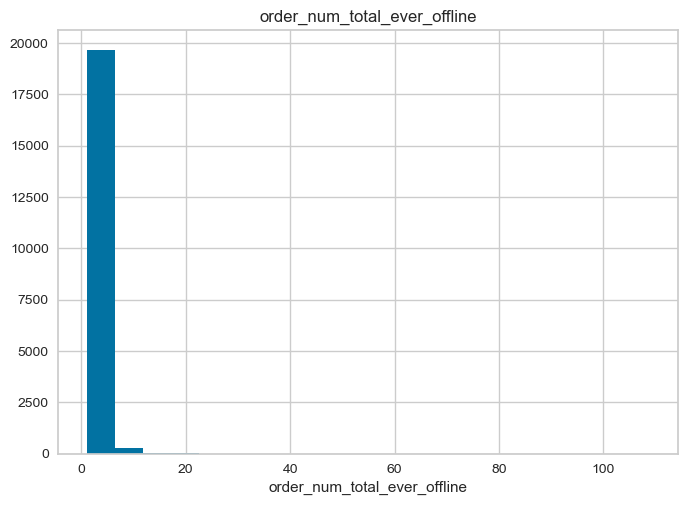

count    19945.000000
mean       253.922597
std        301.532853
min         10.000000
5%          39.990000
10%         59.990000
20%         89.980000
30%        110.480000
40%        140.230000
50%        179.980000
60%        220.860000
70%        281.868000
80%        365.058000
90%        519.950000
95%        694.222000
99%       1219.946800
max      18119.140000
Name: customer_value_total_ever_offline, dtype: float64


count    19945.000000
mean       497.321690
std        832.601886
min         12.990000
5%          63.990000
10%         84.990000
20%        125.990000
30%        173.970000
40%        219.990000
50%        286.460000
60%        371.944000
70%        491.526000
80%        690.868000
90%       1082.036000
95%       1556.726000
99%       3143.810400
max      45220.130000
Name: customer_value_total_ever_online, dtype: float64


count    19945.000000
mean      1965.302833
std        523.396883
min       1169.000000
5%        1373.200000
10%       1502.000000
20%       1642.000000
30%       1713.000000
40%       1764.000000
50%       1815.000000
60%       1894.000000
70%       1978.000000
80%       2131.200000
90%       2708.000000
95%       3238.000000
99%       3769.000000
max       4224.000000
Name: tenure, dtype: float64


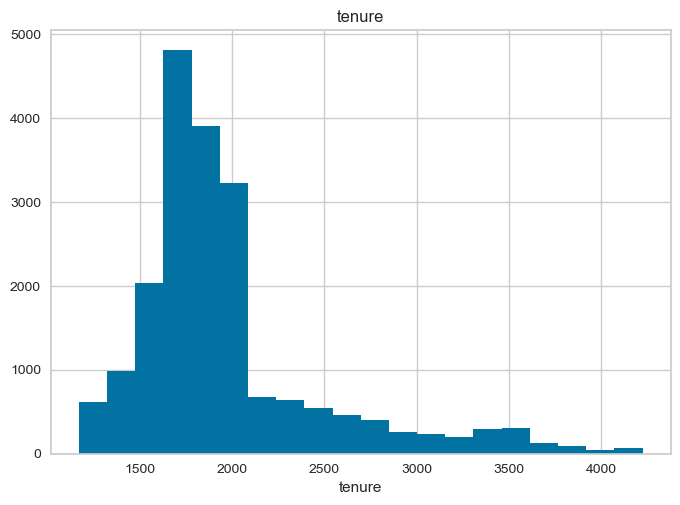

count    19945.000000
mean      1298.458360
std        103.281149
min       1166.000000
5%        1173.000000
10%       1180.000000
20%       1197.000000
30%       1220.000000
40%       1247.000000
50%       1275.000000
60%       1309.000000
70%       1350.000000
80%       1396.000000
90%       1472.000000
95%       1499.000000
99%       1524.000000
max       1531.000000
Name: recency, dtype: float64


count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: frequency, dtype: float64


count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: monetary, dtype: float64


count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: order_num_total, dtype: float64


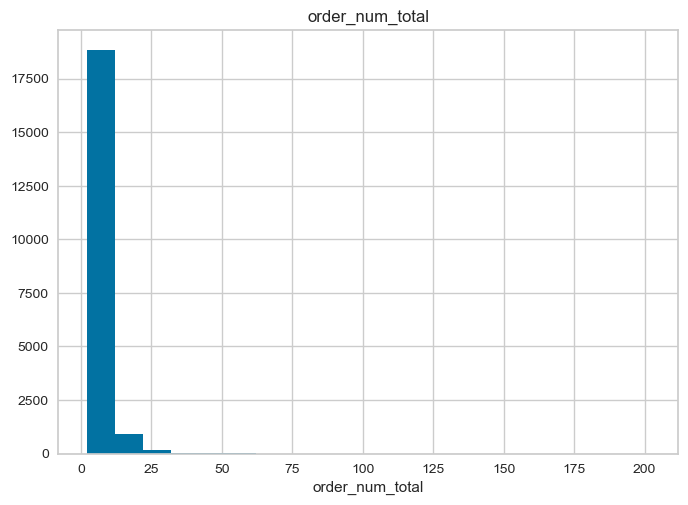

count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: customer_value_total, dtype: float64


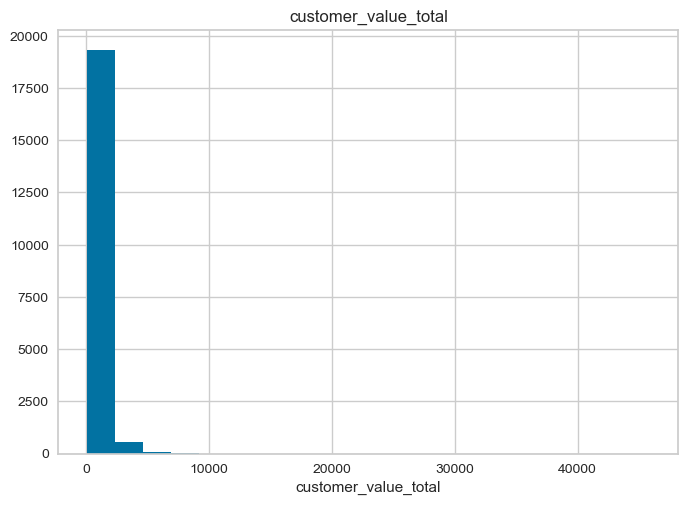

In [10]:
# Examination of numerical variables
df[num_cols].describe().T

for col in num_cols:
     num_summary(df, col, plot=True)

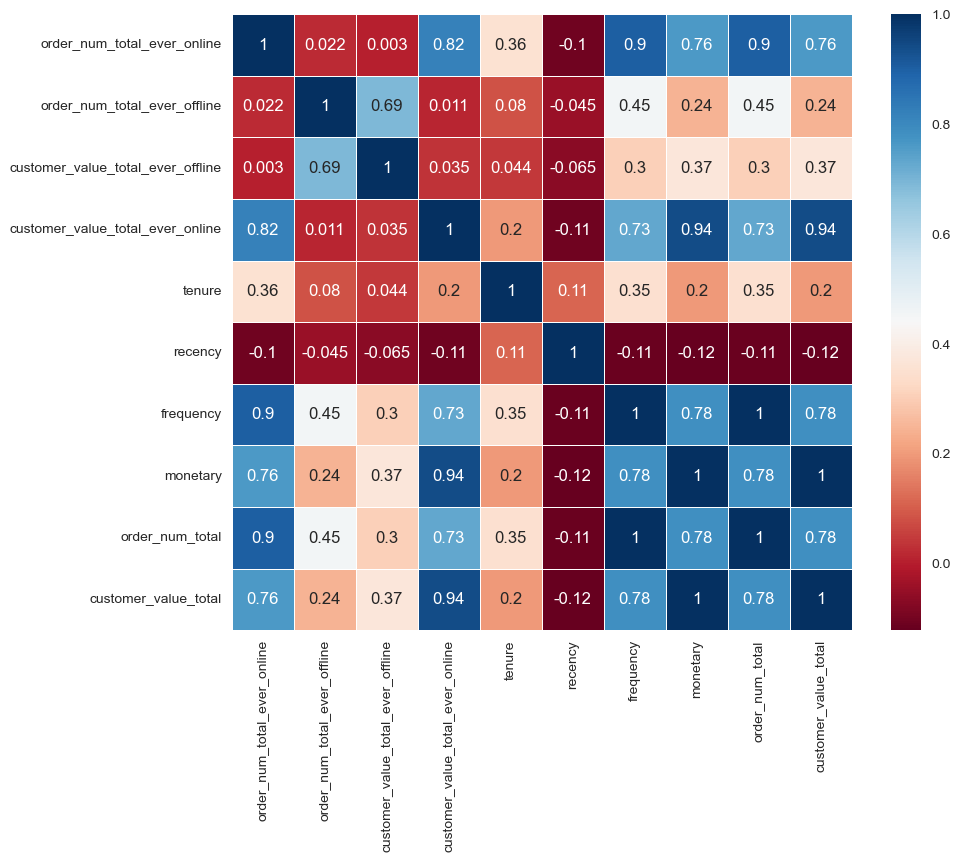

In [11]:
# Correlation of numerical variables with each other
correlation_matrix(df, num_cols)

## 3. Data Preprocessing & Feature Engineering

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [13]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [14]:
ohe_cols = [col for col in df.columns if
            25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [15]:
cat_cols

['order_channel_Desktop',
 'order_channel_Ios App',
 'order_channel_Mobile',
 'last_order_channel_Desktop',
 'last_order_channel_Ios App',
 'last_order_channel_Mobile',
 'last_order_channel_Offline']

In [16]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'tenure',
 'recency',
 'frequency',
 'monetary',
 'order_num_total',
 'customer_value_total']

In [17]:
df.head()

master_id first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12  tenure  recency  frequency  monetary  order_num_total  customer_value_total  order_channel_Desktop  order_channel_Ios App  order_channel_Mobile  last_order_channel_Desktop  last_order_channel_Ios App  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f       2020-10-30      2021-02-26             2021-02-21              2021-02-26                          4.0                           1.0                             139.99                            799.38                           [KADIN]    1378     1259        5.0    939.37              5.0                939.37                      0                      0                     0                           0                           0   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f       2017-02-08      2021-02-16             2021-02-16              2020-01-10                         19.0                           2.0                             159.97                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]    2738     1269       21.0   2013.55             21.0               2013.55                      0                      0                     0                           0                           0   
2  69b69676-1a40-11ea-941b-000d3a38a36f       2019-11-27      2020-11-27             2020-11-27              2019-12-01                          3.0                           2.0                             189.97                            395.35                    [ERKEK, KADIN]    1716     1350        5.0    585.32              5.0                585.32                      0                      0                     0                           0                           0   
3  1854e56c-491f-11eb-806e-000d3a38a36f       2021-01-06      2021-01-17             2021-01-17              2021-01-06                          1.0                           1.0                              39.99                             81.98               [AKTIFCOCUK, COCUK]    1310     1299        2.0    121.97              2.0                121.97                      0                      0                     0                           0                           0   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       2019-08-03      2021-03-07             2021-03-07              2019-08-03                          1.0                           1.0                              49.99                            159.99                       [AKTIFSPOR]    1832     1250        2.0    209.98              2.0                209.98                      1                      0                     0                           1                           0   

   last_order_channel_Mobile  last_order_channel_Offline  
0                          0                           1  
1                          1                           0  
2                          0                           0  
3                          0                           0  
4                          0                           0

In [18]:
df.shape

(19945, 23)

## 4. Customer Segmentation with K-Means

K-Means is a clustering algorithm used to divide a dataset into clusters. This algorithm creates clusters using the coordinates of the points in the dataset. Therefore, the K-Means algorithm can only be applied for numerical variables. The K-Means algorithm determines a center point to divide the dataset into its clusters. These center points are the average of the coordinates of the points in the dataset. The K-Means algorithm assigns each point to the nearest centre.

In [19]:
sc = StandardScaler()
X = sc.fit_transform(df[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X.head()

order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508

For the K-Means algorithm to work, it is necessary to determine the optimum clusters. The Elbow method can be used for this. For the Elbow method, the WCSS values of the clusters must be calculated. WCSS values decrease with increasing number of clusters. Looking at the graph of these values, the decrease slows down after a point. After this point, increasing the number of clusters will not work. This point is called the Elbow point

In [20]:
wcss = []  # We created a list to hold WCSS values.
for k in range(1, 15):  # We looped the numbers from 1 to 15.
    kmeans = KMeans(n_clusters=k).fit(X)  # We ran the K-Means algorithm.
    wcss.append(kmeans.inertia_)  # We added the WCSS values to the wcss list.

plt.plot(range(1, 15), wcss, 'bx-')  # We plotted the WCSS values.
plt.xlabel('k values')
plt.ylabel('WCSS')  
plt.title('The Elbow Method')  
plt.show()  


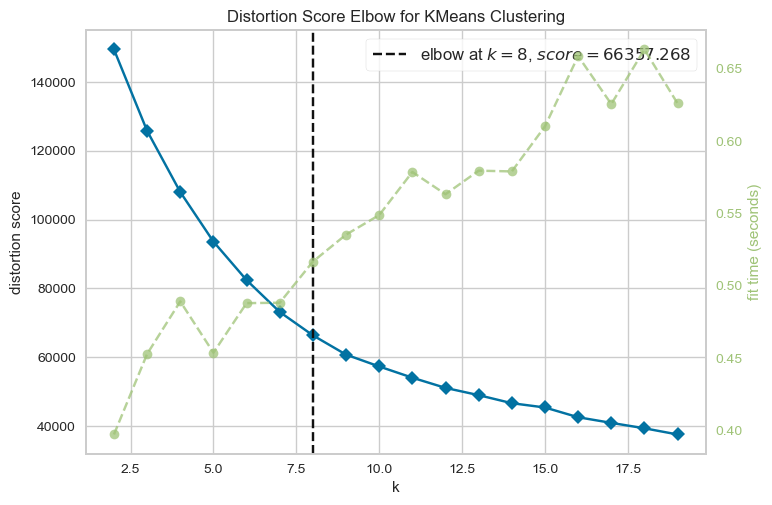

8

In [21]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show(block=True)

elbow.elbow_value_


In [22]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, init='k-means++').fit(X)
kmeans.cluster_centers_  # Indicates the centers of clusters.

array([[-0.31410621, -0.19644441, -0.23113795, -0.25620106, -0.24871087,
         1.1731662 , -0.36530682, -0.31606934, -0.36530682, -0.31606934],
       [-0.14681907,  1.43191079,  1.72924408, -0.0965224 , -0.03999275,
        -0.29746512,  0.49200907,  0.49258219,  0.49200907,  0.49258219],
       [20.32618901, -0.16602674,  0.860791  , 32.33279837,  1.6305654 ,
        -0.8910832 , 18.03796981, 30.3549695 , 18.03796981, 30.3549695 ],
       [ 4.16887774,  0.29748701,  0.23101217,  3.36393289,  1.45288075,
        -0.40379112,  3.84377227,  3.20579368,  3.84377227,  3.20579368],
       [ 0.04658278, 25.28712872, 18.67014342,  0.3528747 , -0.03952635,
         0.07078788, 11.04035317,  6.6154248 , 11.04035317,  6.6154248 ],
       [ 0.0638393 , -0.04210897, -0.06110576, -0.12492725,  2.28919149,
         0.29135777,  0.03856375, -0.13674309,  0.03856375, -0.13674309],
       [ 1.20733538, -0.05304041, -0.09741626,  1.04538008,  0.41597711,
        -0.34107138,  1.05263873,  0.93925528

In [23]:
kmeans.n_clusters  # Indicates the number of clusters.

8

In [24]:
kmeans.labels_

array([7, 3, 0, ..., 7, 1, 0])

In [25]:
kmeans.inertia_  # Displays the WCSS value.

65754.84693922618

In [26]:
kmeans.get_params()  # With get_params() we can see the parameters of the kmeans model.

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [27]:
X[0:5]

order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508

### Build your model and segment your customers

In [28]:
clusters_kmeans = kmeans.labels_    # Indicates which observation the clusters belong to.
X["cluster"] = clusters_kmeans   # We added a variable named cluster_no to X.
X.head()

order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total  cluster
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107        7
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799        3
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312        0
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802        7
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508        7

In [29]:
X.groupby('cluster').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster').agg(['mean', 'median', 'count', 'std']).T

cluster                                             0            1          2           3          4            5            6            7
order_num_total_ever_online       mean      -0.313924    -0.146676  20.326189    4.168878   0.046583     0.063839     1.208596    -0.280542
                                  median    -0.499547    -0.262891  15.593067    3.760263  -0.262891    -0.026234     1.157046    -0.499547
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.271743     0.390003  14.238753    1.991831   0.787183     0.521259     0.676832     0.288049
order_num_total_ever_offline      mean      -0.196401     1.431410  -0.166027    0.297487  25.287129    -0.042109    -0.053668    -0.184639
                                  median    -0.443039     1.011275  -0.443039    0.041732  21.371668    -0.443039    -0.443039    -0.443039
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.375444     1.109955   0.549679    1.058119  13.404403     0.538280     0.500033     0.370217
customer_value_total_ever_offline mean      -0.231081     1.727477   0.860791    0.231012  18.670143    -0.061106    -0.097833    -0.193978
                                  median    -0.344723     1.413753   0.945252   -0.176379  12.415633    -0.212064    -0.243570    -0.311525
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.434838     1.261372   1.513316    1.234738  14.433813     0.583983     0.565329     0.438048
customer_value_total_ever_online  mean      -0.256138    -0.096223  32.332798    3.363933   0.352875    -0.124927     1.046283    -0.224575
                                  median    -0.336714    -0.206408  36.262115    2.883837  -0.305690    -0.194986     0.925518    -0.308795
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.268367     0.376309  14.545352    1.783047   1.322773     0.346127     0.616518     0.279430
tenure                            mean      -0.248751    -0.039867   1.630565    1.452881  -0.039526     2.289191     0.417337    -0.442826
                                  median    -0.321567    -0.182090   1.302481    1.430494   0.056741     2.276909     0.066294    -0.426652
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.463044     0.655765   2.274596    1.333438   0.534017     0.823213     1.036778     0.473817
recency                           mean       1.173022    -0.296592  -0.891083   -0.403791   0.070788     0.291358    -0.342324    -0.638817
                                  median     1.080008    -0.498248  -0.992058   -0.711264  -0.488566     0.179530    -0.575709    -0.701582
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.614139     0.806082   0.267448    0.838121   1.071663     0.992987     0.838363     0.450431
frequency                         mean      -0.365125     0.491919  18.037970    3.843772  11.040353     0.038564     1.053489    -0.330267
                                  median    -0.426933     0.416488  13.700374    3.368463   9.272412    -0.005222     0.838199    -0.426933
                                  count   5472.000000  1680.000000   7.000000  417.000000  13.000000  1671.000000  1997.000000  8688.000000
                                  std        0.284668     0.591306  12.713170   

In [30]:
X['cluster'] = X['cluster'] + 1
X.head()


order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total  cluster
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107        8
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799        4
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312        1
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802        8
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508        8

In [31]:
X["cluster"].value_counts()                 # It shows the number of observations belonging to each cluster.
X["cluster"].value_counts() / len(X) * 100

8    43.559789
1    27.435447
7    10.012534
2     8.423164
6     8.378040
4     2.090750
5     0.065179
3     0.035097
Name: cluster, dtype: float64

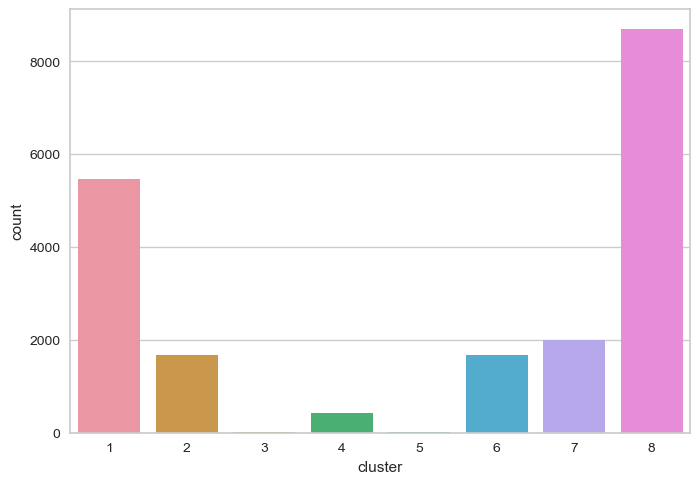

In [32]:
sns.countplot(x='cluster', data=X)
plt.show()

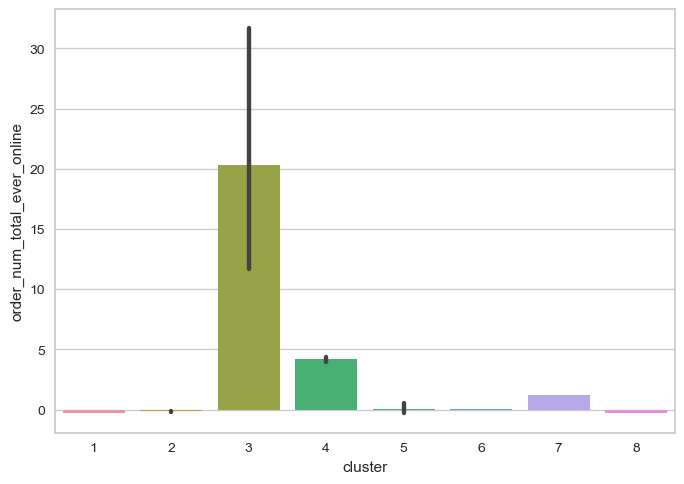

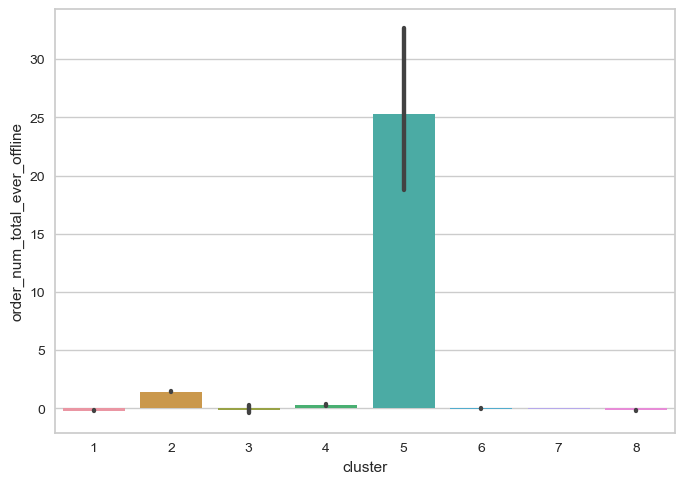

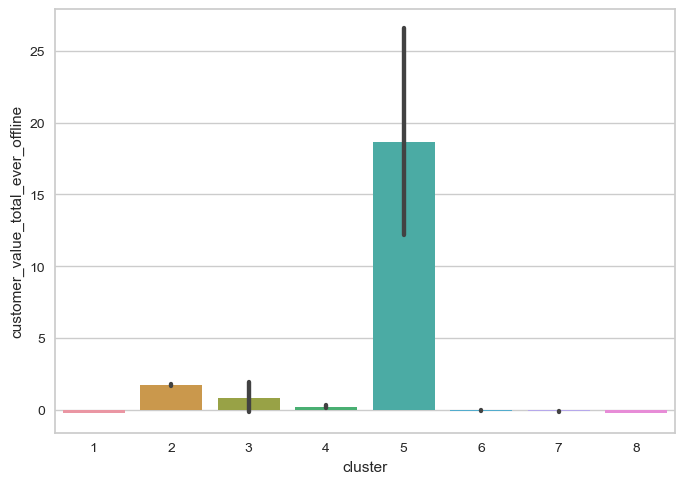

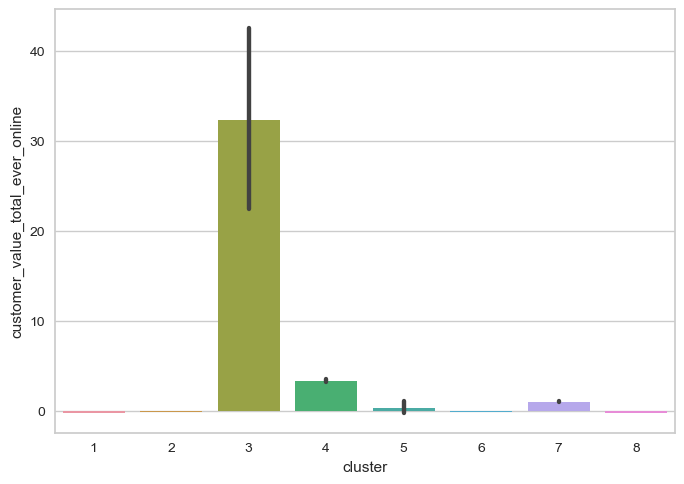

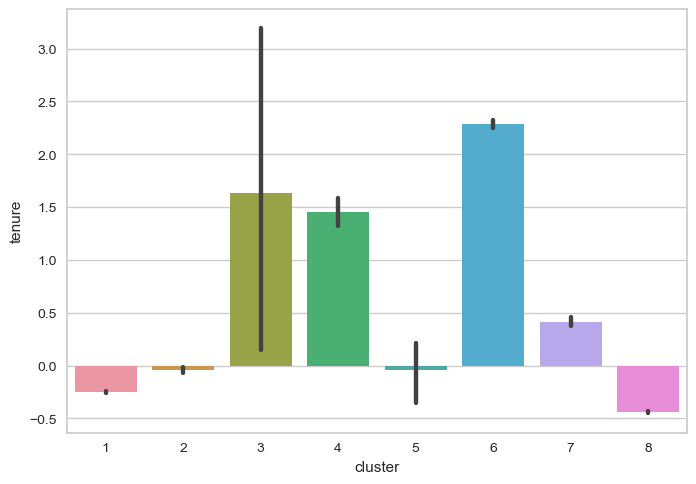

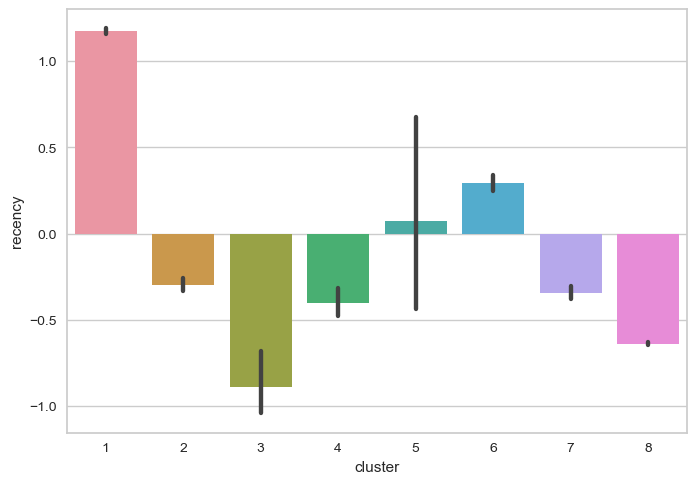

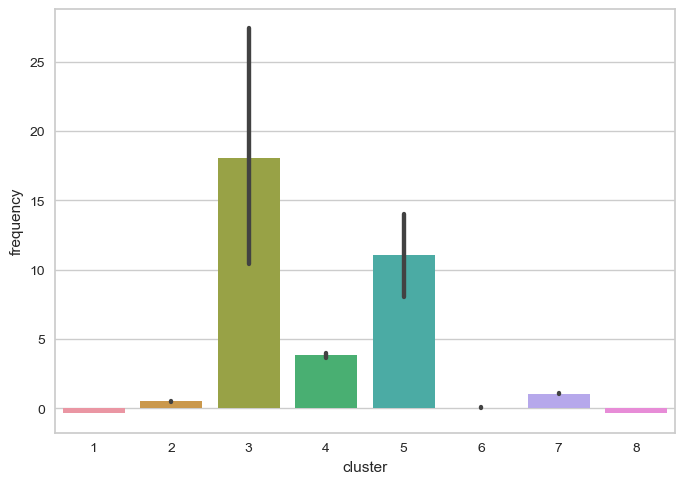

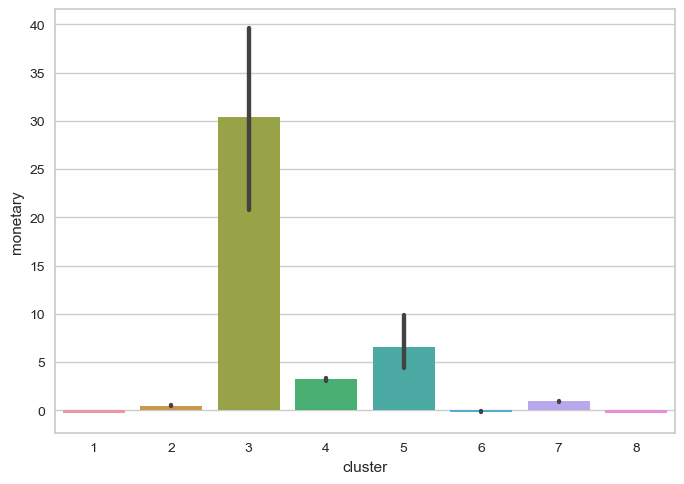

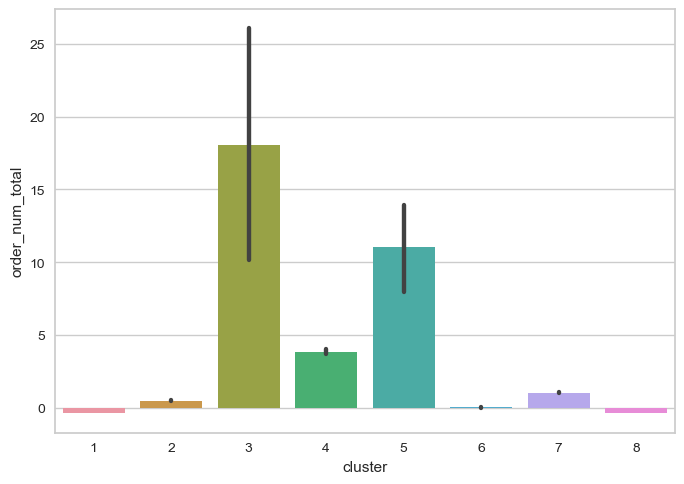

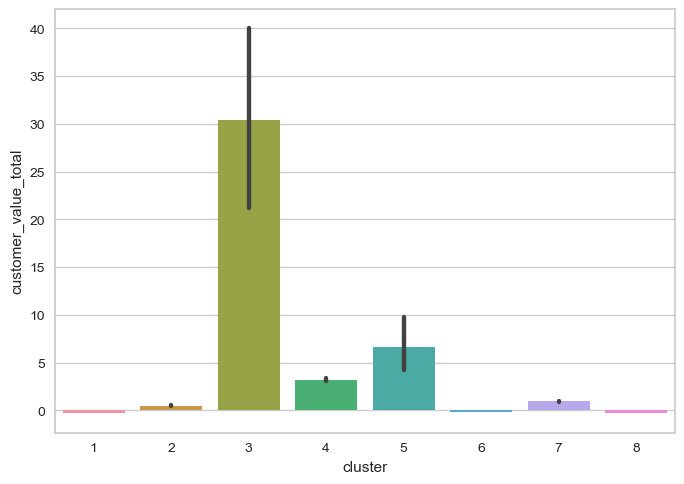

In [33]:
for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

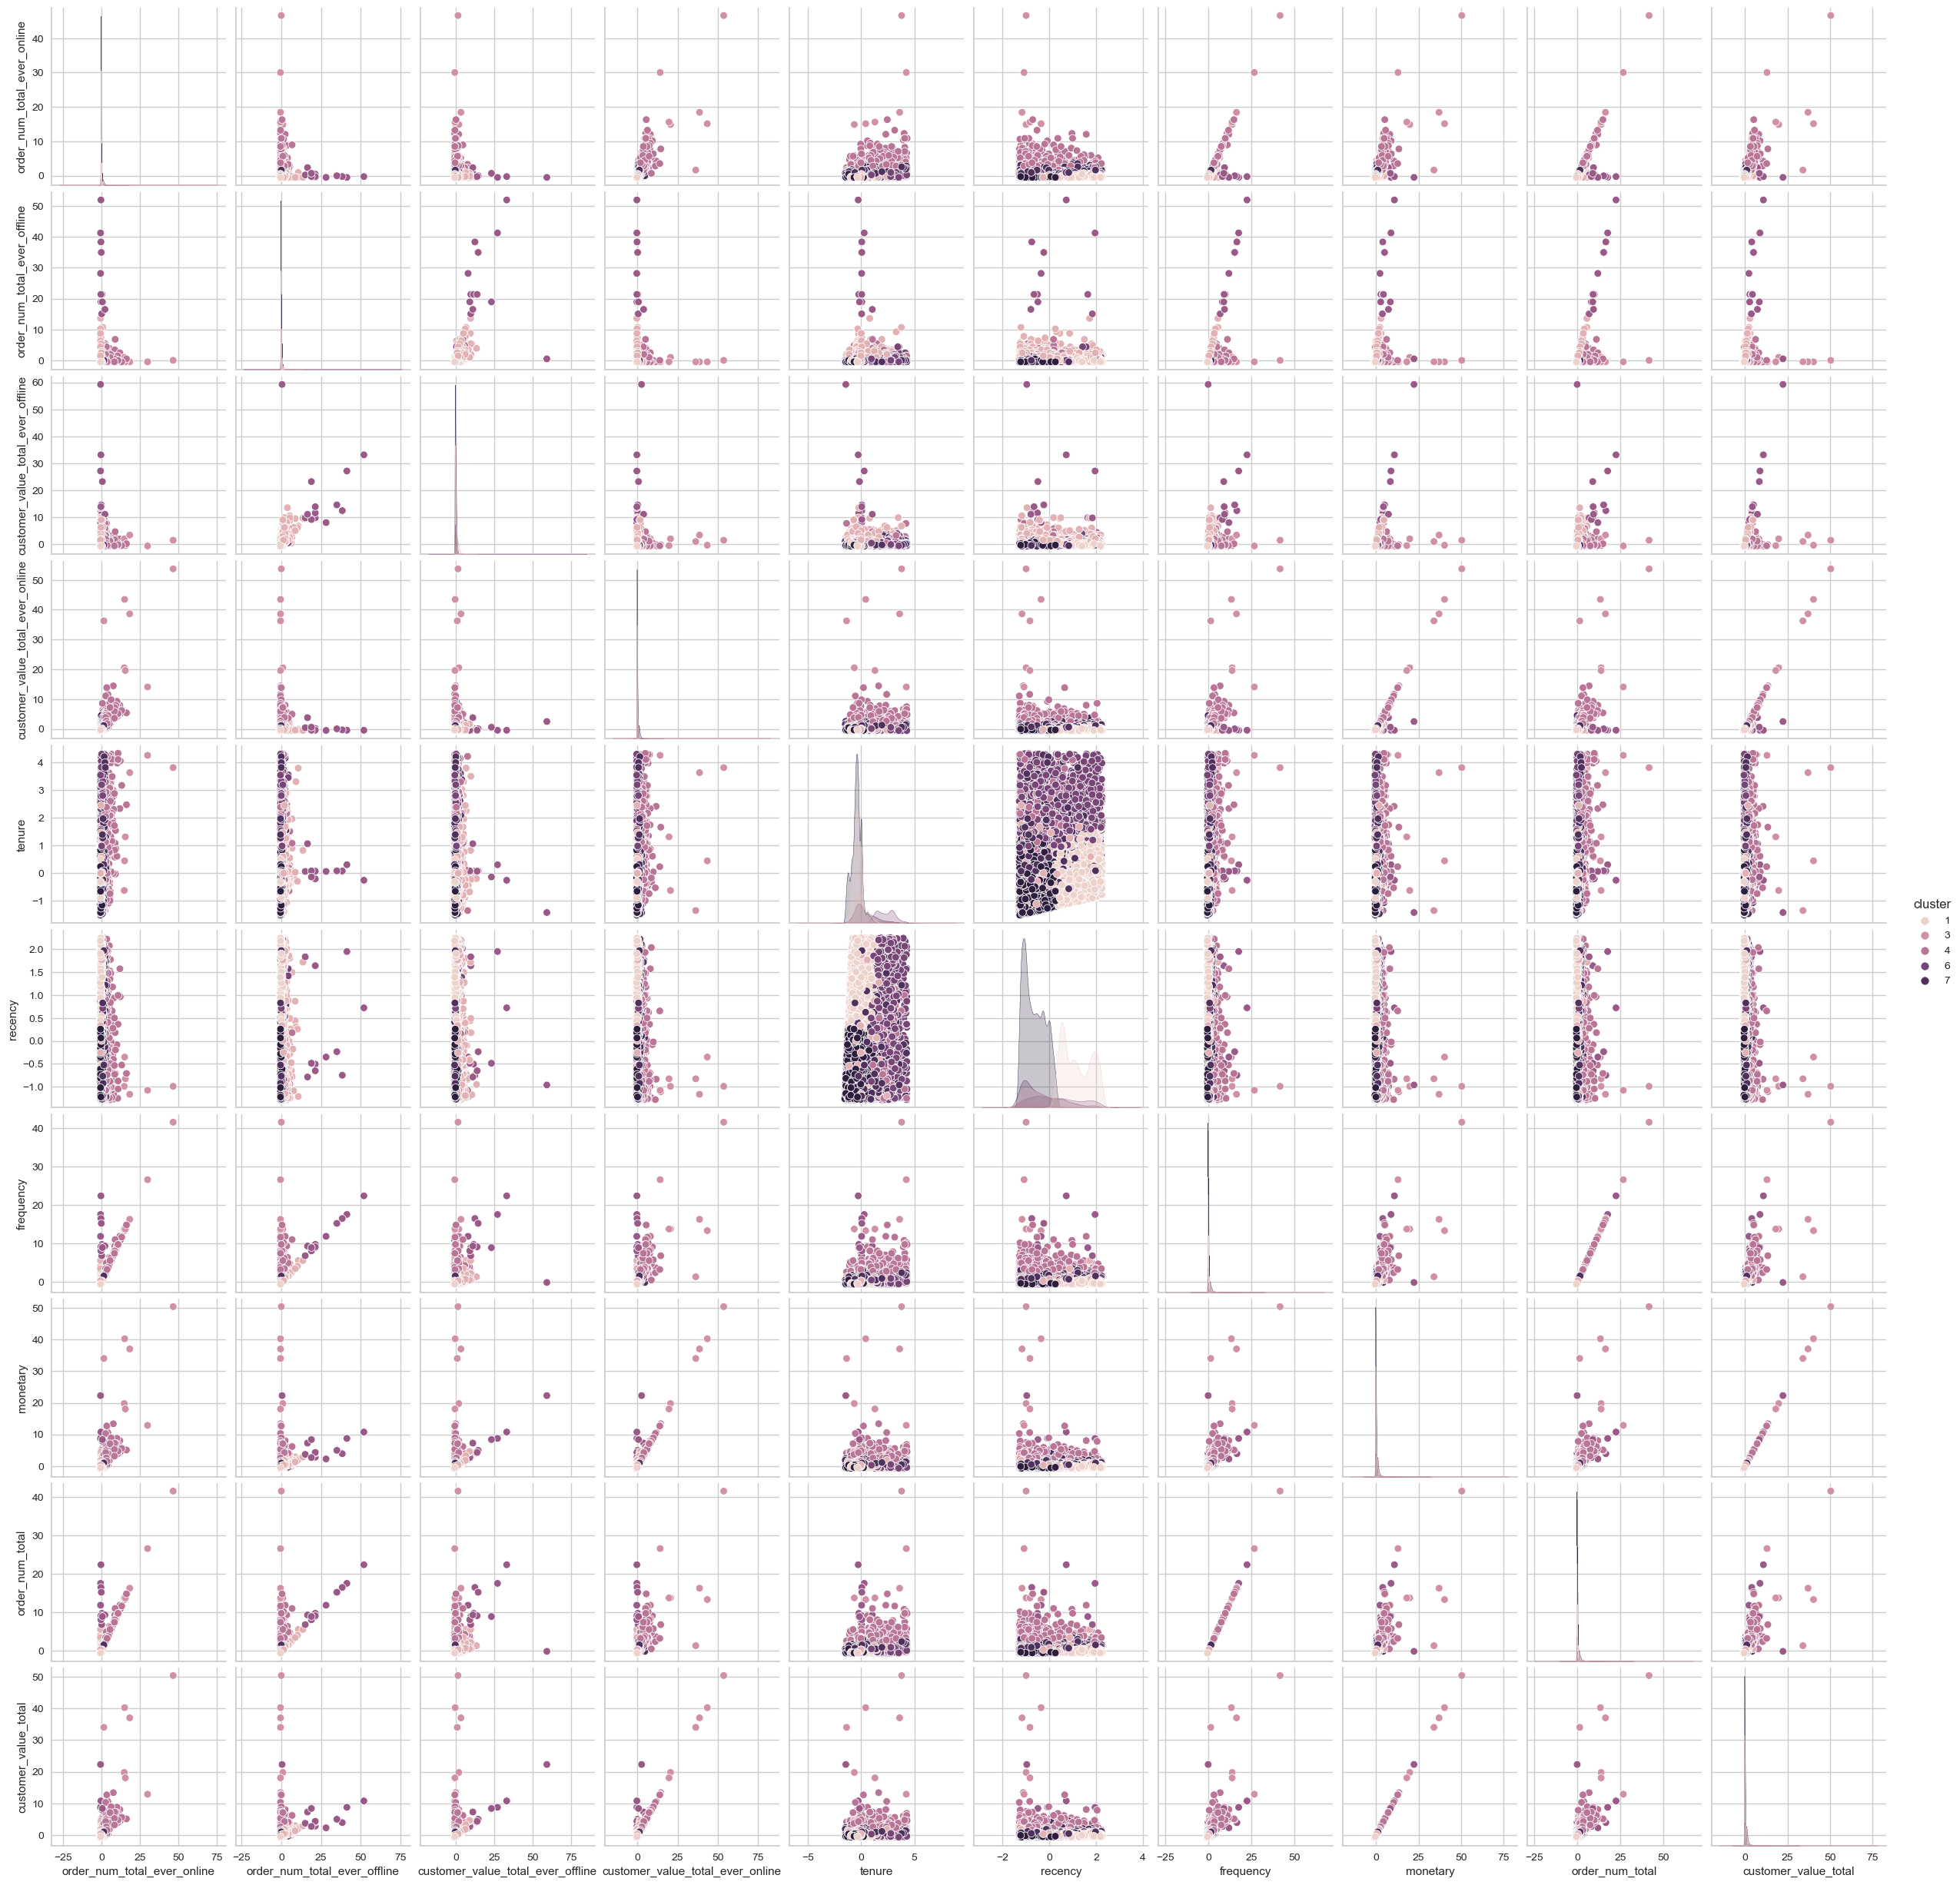

In [34]:
sns.pairplot(X, hue='cluster')
plt.show()

### 5. Customer Segmentation with Hierarchical Clustering

The Hierarchical Clustering (HC) method is a clustering method used to separate data points into groups with similar characteristics. This method is used to group data points about each other. Each of these groups is called a cluster.

The HC method is also called the link matrix method. This method is used to group data points according to their degree of connectivity to each other. This method creates a connectivity matrix to measure the degrees of relationship between data points. This matrix shows the degrees of connectivity between the data points and clusters the data points according to these degrees.

The connectivity matrix method clusters data points according to their degree of similarity and is used to measure the degree of association between data points. This method creates cluster centers according to the similarity degrees of the data points and places the data points in the clusters closest to these cluster centers. The connectivity matrix method is used to best group the data points and this method is used to measure the degrees of relationship between the data points. The differences between these methods are how they place the data points into clusters.

In this snippet, a link matrix is created that measures the degree of similarity of data points using the linkage() function of the scipy library. Then, using this link matrix, a dendogram is created with the HC method using the dendrogram() function of the scipy library. This dendogram is displayed using the show() function of the matplotlib library. In this snippet, the method parameter is specified as 'ward', so the hc_ward method is used as the HC method. This parameter value can take different values such as 'single', 'complete' or 'average' and according to these values, a dendogram can be obtained by applying the HC method with different methods

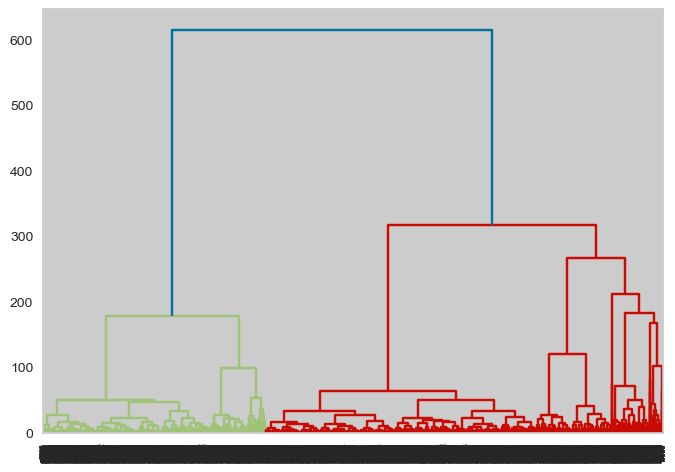

In [55]:
linkage_matrix = linkage(X, method='ward')

# Create the dendrogram
dend = dendrogram(linkage_matrix)

# Show the dendrogram
plt.show()

In [56]:
hc_average = linkage(X, "average")  # We created a connection matrix with the average method.
hc_ward = linkage(X, "ward")  # We created a connection matrix with the ward method.
hc_complete = linkage(X, "complete")  # We created a connection matrix with the complete method.
hc_single = linkage(X, "single")  # We created a connection matrix with the single method.
hc_centroid = linkage(X, "centroid")  # We created a connection matrix with the centroid method.

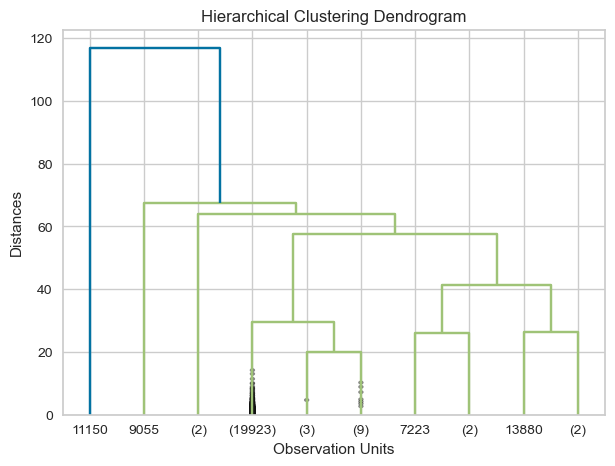

In [57]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

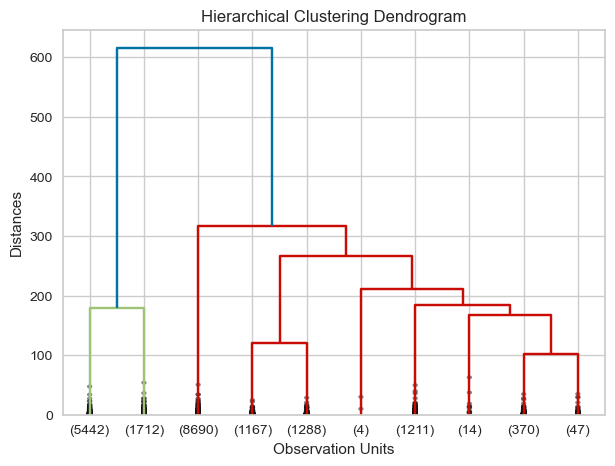

In [58]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_ward,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

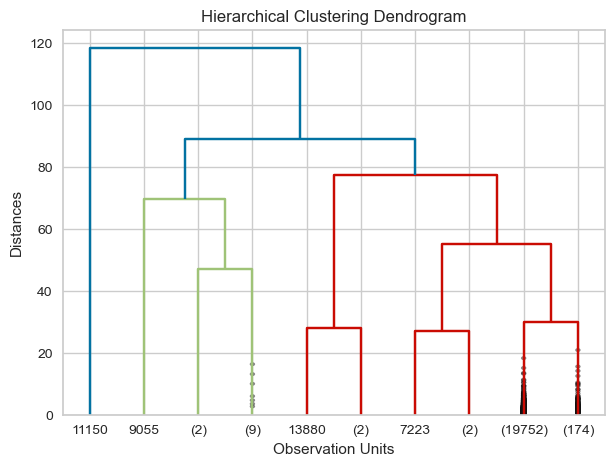

In [59]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

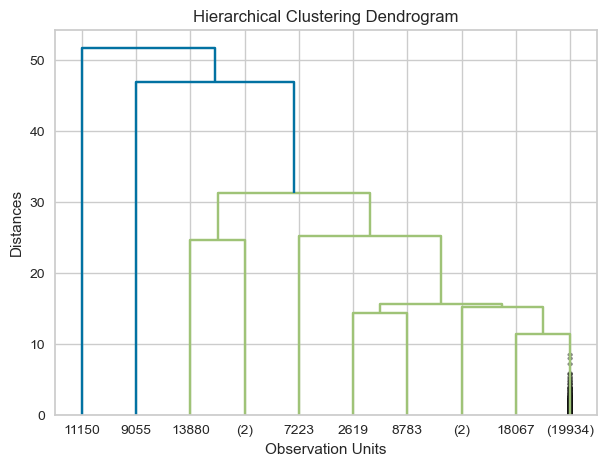

In [60]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_single,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

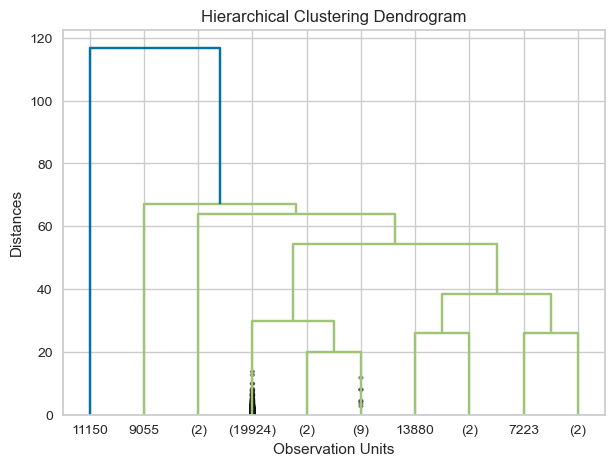

In [61]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_centroid,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

We are using the AgglomerativeClustering class from scikit-learn to perform hierarchical clustering on a dataset X. We are setting the number of clusters to 3 and using the Euclidean distance and the Ward linkage method for clustering.

The fit_predict method fits the model to the data and returns the cluster labels for each sample in the dataset. The cluster labels are stored in the clusters_hc array.

After running this code, we can use the clusters_hc array to see the cluster labels for each sample in the dataset. For example, if the first sample has a cluster label of 0, it belongs to the first cluster. If the second sample has a cluster label of 1, it belongs to the second cluster, and so on.

In [62]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(X)
clusters_hc

X['cluster_hc'] = clusters_hc
X['cluster_hc'] = X['cluster_hc'] + 1
X.head()

order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total  cluster  cluster_dbscan  cluster_hc
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107        8               1           3
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799        4               0           1
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312        1               2           2
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802        8               1           3
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508        8               1           3

In [63]:
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std']).T

cluster_hc                                          1            2            3
order_num_total_ever_online       mean       1.071293    -0.273443    -0.280456
                                  median     0.683734    -0.499547    -0.499547
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.751620     0.317130     0.288077
order_num_total_ever_offline      mean       0.068093     0.185185    -0.184587
                                  median     0.041732     0.041732    -0.443039
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.717948     0.922958     0.370191
customer_value_total_ever_offline mean       0.007690     0.230970    -0.193774
                                  median    -0.212097    -0.178866    -0.311525
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.467806     1.105064     0.438211
customer_value_total_ever_online  mean       0.855322    -0.217782    -0.224357
                                  median     0.574729    -0.311503    -0.308428
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.900790     0.307120     0.279767
tenure                            mean       1.286072    -0.199434    -0.442742
                                  median     1.304391    -0.294818    -0.426652
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.329995     0.524935     0.473801
recency                           mean      -0.089225     0.826902    -0.638636
                                  median    -0.314280     0.808896    -0.701582
                                  count   4101.000000  7154.000000  8690.000000
                                  std        0.959215     0.911295     0.450540
frequency                         mean       0.984116    -0.163084    -0.330168
                                  median     0.627344    -0.426933    -0.426933
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.720350     0.526512     0.287535
monetary                          mean       0.797922    -0.124727    -0.273876
                                  median     0.480261    -0.263887    -0.329904
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.846217     0.509478     0.291683
order_num_total                   mean       0.984116    -0.163084    -0.330168
                                  median     0.627344    -0.426933    -0.426933
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.720350     0.526512     0.287535
customer_value_total              mean       0.797922    -0.124727    -0.273876
                                  median     0.480261    -0.263887    -0.329904
                                  count   4101.000000  7154.000000  8690.000000
                                  std        1.846217     0.509478     0.291683
cluster                           mean       6.275299     1.235952     7.999770
                                  median     6.000000     1.000000     8.000000
                                  count   4101.000000  7154.000000  8690.000000
                                  std        0.914942     0.427575     0.015170
cluster_dbscan                    mean       2.708608     2.007408     0.998734
                                  median     4.000000     2.000000     1.000000
                                  count   4101.000000  7154.000000  8690.000000
                                  std        2.251546     0.702754     0.035558

In [64]:
X["cluster_hc"].value_counts()                 # It shows the number of observations belonging to each cluster.
X["cluster_hc"].value_counts() / len(X) * 100

3    43.569817
2    35.868639
1    20.561544
Name: cluster_hc, dtype: float64

In [65]:
sns.countplot(x='cluster_hc', data=X)
plt.show()

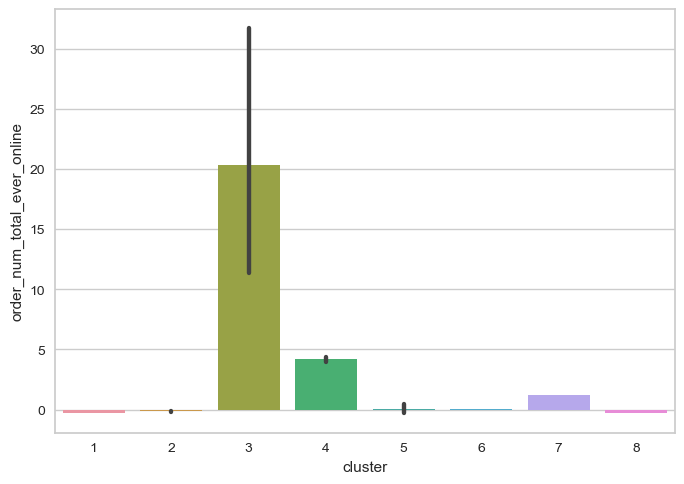

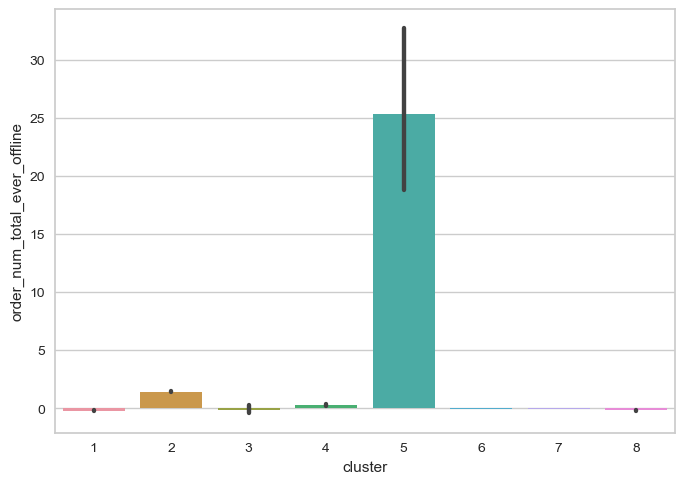

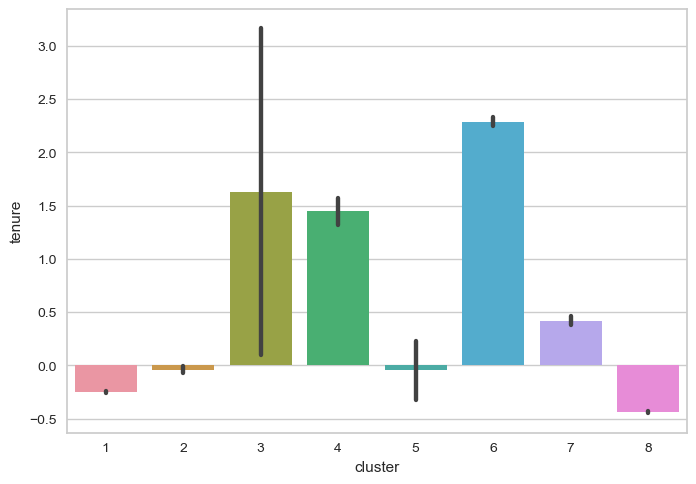

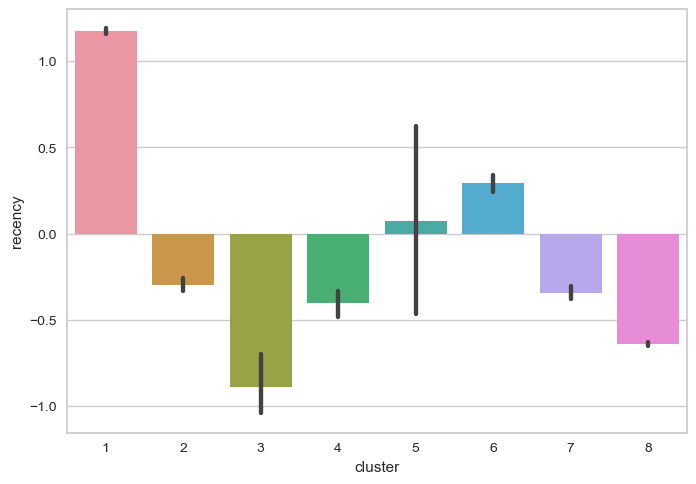

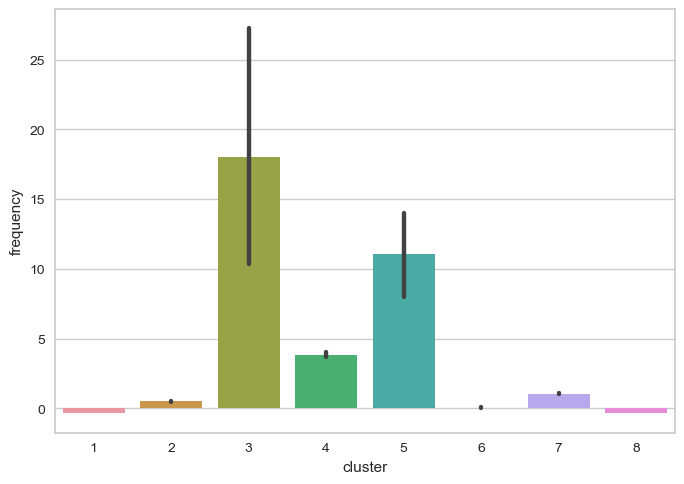

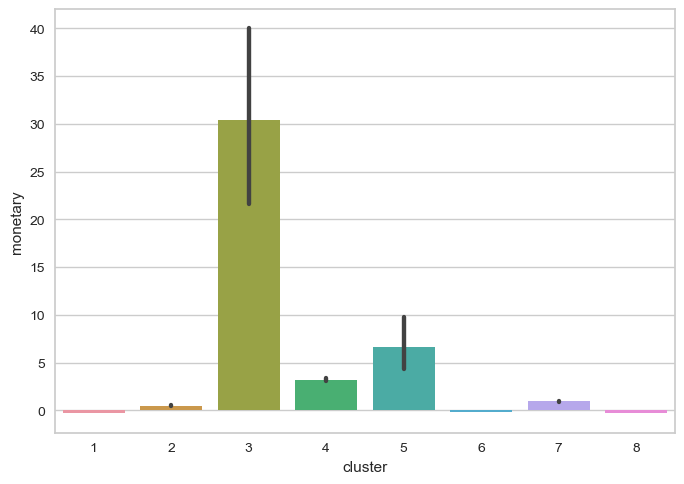

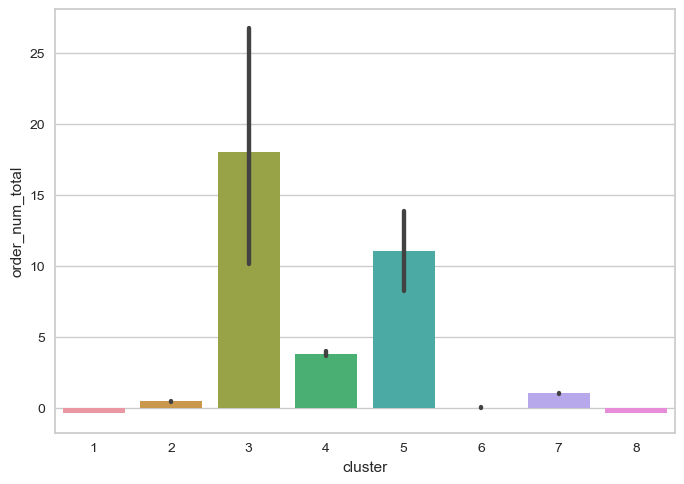

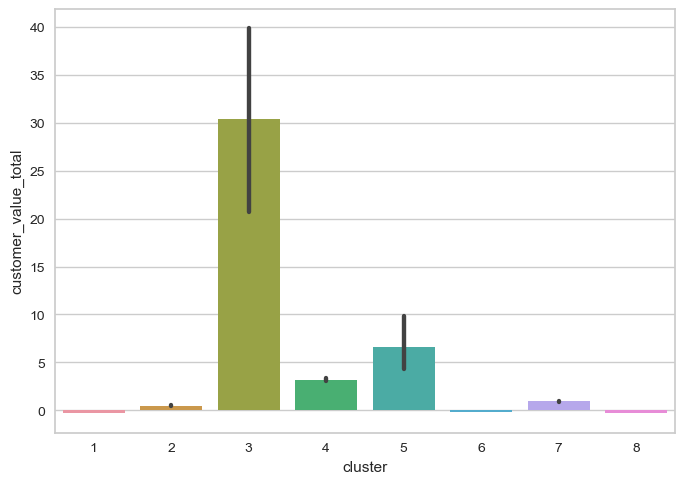

In [66]:
for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

In [67]:
sns.pairplot(X, hue='cluster')
plt.show()

## 6. Customer Segmentation with DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that is based on the density of data points. It can be used for customer segmentation by finding groups of similar customers based on their characteristics or attributes.

Use the DBSCAN class from scikit-learn to fit the model to your data. You'll need to specify two important parameters: eps and min_samples. eps is the maximum distance between two points in the same cluster, and min_samples is the minimum number of points required to form a cluster.

In [35]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15)
clusters = dbscan.fit_predict(X)
print(clusters)
df['dbscan_cluster'] = clusters
df.head()

[ 0 -1  1 ...  0  2  1]


master_id first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12  tenure  recency  frequency  monetary  order_num_total  customer_value_total  order_channel_Desktop  order_channel_Ios App  order_channel_Mobile  last_order_channel_Desktop  last_order_channel_Ios App  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f       2020-10-30      2021-02-26             2021-02-21              2021-02-26                          4.0                           1.0                             139.99                            799.38                           [KADIN]    1378     1259        5.0    939.37              5.0                939.37                      0                      0                     0                           0                           0   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f       2017-02-08      2021-02-16             2021-02-16              2020-01-10                         19.0                           2.0                             159.97                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]    2738     1269       21.0   2013.55             21.0               2013.55                      0                      0                     0                           0                           0   
2  69b69676-1a40-11ea-941b-000d3a38a36f       2019-11-27      2020-11-27             2020-11-27              2019-12-01                          3.0                           2.0                             189.97                            395.35                    [ERKEK, KADIN]    1716     1350        5.0    585.32              5.0                585.32                      0                      0                     0                           0                           0   
3  1854e56c-491f-11eb-806e-000d3a38a36f       2021-01-06      2021-01-17             2021-01-17              2021-01-06                          1.0                           1.0                              39.99                             81.98               [AKTIFCOCUK, COCUK]    1310     1299        2.0    121.97              2.0                121.97                      0                      0                     0                           0                           0   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       2019-08-03      2021-03-07             2021-03-07              2019-08-03                          1.0                           1.0                              49.99                            159.99                       [AKTIFSPOR]    1832     1250        2.0    209.98              2.0                209.98                      1                      0                     0                           1                           0   

   last_order_channel_Mobile  last_order_channel_Offline  dbscan_cluster  
0                          0                           1               0  
1                          1                           0              -1  
2                          0                           0               1  
3                          0                           0               0  
4                          0                           0               0

In [36]:
X['cluster_dbscan'] = clusters
X['cluster_dbscan'] = X['cluster_dbscan'] + 1
X.head()

order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online    tenure   recency  frequency  monetary  order_num_total  customer_value_total  cluster  cluster_dbscan
0                     0.210422                     -0.443039                          -0.377854                          0.362797 -1.122127 -0.382058  -0.005222  0.210107        -0.005222              0.210107        8               1
1                     3.760263                      0.041732                          -0.311591                          1.628981  1.476349 -0.285232   3.368463  1.409799         3.368463              1.409799        4               0
2                    -0.026234                      0.041732                          -0.212097                         -0.122477 -0.476329  0.499055  -0.005222 -0.185312        -0.005222             -0.185312        1               2
3                    -0.499547                     -0.443039                          -0.709501                         -0.498860 -1.252050  0.005244  -0.637788 -0.702802        -0.637788             -0.702802        8               1
4                    -0.499547                     -0.443039                          -0.676337                         -0.405164 -0.254694 -0.469201  -0.637788 -0.604508        -0.637788             -0.604508        8               1

In [37]:
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std']).T

cluster_dbscan                                      0            1            2            3            4            5         6
order_num_total_ever_online       mean       1.517949    -0.280696    -0.316075    -0.230949     0.944522    -0.042587  0.447078
                                  median     1.157046    -0.499547    -0.499547    -0.262891     0.920390    -0.026234  0.447078
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        2.208498     0.288089     0.269273     0.298792     0.447376     0.423058  0.000000
order_num_total_ever_offline      mean       0.754798    -0.184483    -0.197625     1.219884    -0.155582    -0.170543  1.226729
                                  median     0.041732    -0.443039    -0.443039     1.011275    -0.443039    -0.443039  1.011275
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        2.480136     0.370321     0.373755     0.636567     0.373366     0.371304  0.255497
customer_value_total_ever_offline mean       0.905310    -0.195133    -0.236092     1.296829    -0.228692    -0.196169  1.039023
                                  median     0.359132    -0.311525    -0.344723     1.216042    -0.311558    -0.308275  1.011382
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        2.319392     0.436494     0.428528     0.633570     0.393673     0.422798  0.248227
customer_value_total_ever_online  mean       1.277104    -0.225286    -0.259224    -0.171815     0.816135    -0.176676  0.359162
                                  median     0.830992    -0.309077    -0.337915    -0.252626     0.766938    -0.247107  0.390422
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        2.439593     0.278455     0.262949     0.292632     0.412746     0.306579  0.195819
tenure                            mean       1.170434    -0.442567    -0.251262    -0.198344     0.085160     2.125471  0.059076
                                  median     1.048365    -0.426652    -0.321567    -0.216481    -0.015864     2.041900  0.051009
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        1.431881     0.473719     0.460223     0.350611     0.646213     0.745343  0.149020
recency                           mean      -0.038735    -0.639450     1.170273    -0.392954    -0.532564     0.256344  0.756180
                                  median    -0.285232    -0.701582     1.070325    -0.527296    -0.730629     0.131118  0.663658
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        1.015567     0.449959     0.613811     0.691665     0.642225     0.974278  0.218454
frequency                         mean       1.680765    -0.330337    -0.367574     0.324828     0.773876    -0.112124  0.931912
                                  median     1.259910    -0.426933    -0.426933     0.205633     0.838199    -0.216078  0.838199
                                  count   2219.000000  8679.000000  5442.000000  1141.000000  1167.000000  1288.000000  9.000000
                                  std        2.071005     0.287581     0.281487     0.340818     0.389239     0.373579  0.111131
monetary                          mean       1.492402    -0.275197    -0.320549     0.276951     0.681881    -0.230346  0.683870
                                  median     1.104331    -0.330390    -0.374433     0.250235     0.652791    -0.262402  0.708745
 

In [38]:
X["cluster_dbscan"].value_counts() 

1    8679
2    5442
0    2219
5    1288
4    1167
3    1141
6       9
Name: cluster_dbscan, dtype: int64

In [39]:
sns.countplot(x='cluster_dbscan', data=X)
plt.show()

## Conclusion

Segmenting customers into different groups using their characteristics and behaviors has always been an important topic. Customer segmentation can lead to better customer understanding and targeting, which in turn leads to more effective product tailoring and marketing strategies. Data mining methods are powerful techniques that can be used in customer segmentation to find customers with similar characteristics.

What is RFM?
It is a score that consists of the initials of the words Recency, Frequency, and Monetary, and is formed by combining these three metrics after calculating them. It helps customers to analyze their current status and segment them according to these scores.

Recency: It gives information such as how long the customer has received service from the website/store, and how long he has been a member. The calculation is usually obtained by subtracting the last subscription date/last order date from today.
Frequency: It is the metric that shows how often the customer makes a purchase and how often he logs into the site. It usually results in counting the order number/order code.
Monetary: It is the sum of the customer’s expenses. The turnover brought to the e-commerce site can also be defined as the revenue collected after the services it receives.
Recently, the concept of ‘Tenure’ has started to be included in RFM analysis as a new metric. Tenure, on the other hand, is the time elapsed since the customer’s first contact with the e-commerce site/store. It can be found by subtracting the minimum contact date from today.

 Look at the distribution of the number of customers in the shopping channels, the total number of products purchased, and the total expenditures.

 Rank the top 10 most profitable customers

In [41]:
df.sort_values("customer_value_total", ascending=False).head(10)

df.groupby("master_id").agg({"customer_value_total": "sum"}).sort_values(by="customer_value_total", ascending=False).head(10)

customer_value_total
master_id                                                 
5d1c466a-9cfd-11e9-9897-000d3a38a36f              45905.10
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f              36818.29
73fd19aa-9e37-11e9-9897-000d3a38a36f              33918.10
7137a5c0-7aad-11ea-8f20-000d3a38a36f              31227.41
47a642fe-975b-11eb-8c2a-000d3a38a36f              20706.34
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f              18443.57
d696c654-2633-11ea-8e1c-000d3a38a36f              16918.57
fef57ffa-aae6-11e9-a2fc-000d3a38a36f              12726.10
cba59206-9dd1-11e9-9897-000d3a38a36f              12282.24
fc0ce7a4-9d87-11e9-9897-000d3a38a36f              12103.15

 List the top 10 customers with the most orders

In [42]:
df.sort_values("order_num_total", ascending=False).head(10)

df.groupby("master_id").agg({"order_num_total": "sum"}).sort_values(by="order_num_total", ascending=False).head(10)

order_num_total
master_id                                            
5d1c466a-9cfd-11e9-9897-000d3a38a36f            202.0
cba59206-9dd1-11e9-9897-000d3a38a36f            131.0
a57f4302-b1a8-11e9-89fa-000d3a38a36f            111.0
fdbe8304-a7ab-11e9-a2fc-000d3a38a36f             88.0
329968c6-a0e2-11e9-a2fc-000d3a38a36f             83.0
73fd19aa-9e37-11e9-9897-000d3a38a36f             82.0
44d032ee-a0d4-11e9-a2fc-000d3a38a36f             77.0
b27e241a-a901-11e9-a2fc-000d3a38a36f             75.0
d696c654-2633-11ea-8e1c-000d3a38a36f             70.0
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f             70.0

## Calculating RFM Metrics¶

Step 1: Make the definitions of Recency, Frequency and Monetary.

In [44]:
import datetime as dt
df.head()
df["last_order_date"].max()     #last day of shopping
today_date = dt.datetime(2021, 6, 1)    #The day of the analysis was arranged as 2 after the last day.
type(today_date)

datetime.datetime

In [46]:
df["last_order_date"] = pd.to_datetime(df["last_order_date"])
rfm = pd.DataFrame()       #We create a new rfm dataframe with customer_id, recency, frequnecy and monetary values.
rfm["customer_id"] = df["master_id"]
rfm["recency"] = (today_date - df["last_order_date"]).astype('timedelta64[D]')
rfm["frequency"] = df["order_num_total"]
rfm["monetary"] = df["customer_value_total"]

rfm.head()


customer_id  recency  frequency  monetary
0  cc294636-19f0-11eb-8d74-000d3a38a36f     95.0        5.0    939.37
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f    105.0       21.0   2013.55
2  69b69676-1a40-11ea-941b-000d3a38a36f    186.0        5.0    585.32
3  1854e56c-491f-11eb-806e-000d3a38a36f    135.0        2.0    121.97
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f     86.0        2.0    209.98

Step 2: Calculate the Recency, Frequency and Monetary metrics for the customer.

Step 3: Assign your calculated metrics to a variable named rfm

In [47]:
rfm = df.groupby('master_id').agg({'last_order_date': lambda last_order_date: (today_date - last_order_date.max()).days,
                                      'order_num_total': lambda order_num_total: order_num_total,
                                      'customer_value_total': lambda customer_value_total: customer_value_total.sum()})
rfm.head()

last_order_date  order_num_total  customer_value_total
master_id                                                                                   
00016786-2f5a-11ea-bb80-000d3a38a36f               10              5.0                776.07
00034aaa-a838-11e9-a2fc-000d3a38a36f              298              3.0                269.47
000be838-85df-11ea-a90b-000d3a38a36f              213              4.0                722.69
000c1fe2-a8b7-11ea-8479-000d3a38a36f               27              7.0                874.16
000f5e3e-9dde-11ea-80cd-000d3a38a36f               20              7.0               1620.33

Change the names of the metrics you created to recency, frequency and monetary.

In [48]:
rfm.columns = ["recency", "frequency", "monetary"]
rfm.describe().T

count        mean         std    min     25%     50%     75%      max
recency    19945.0  134.458360  103.281149   2.00   43.00  111.00  202.00    367.0
frequency  19945.0    5.024768    4.742707   2.00    3.00    4.00    6.00    202.0
monetary   19945.0  751.244287  895.402173  44.98  339.98  545.27  897.78  45905.1

## Calculating RF Score

In [49]:
# Step 1: Convert the Recency, Frequency and Monetary metrics to scores between 1-5 with the help of qcut.

rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

In [50]:
rfm.head()

recency  frequency  monetary recency_score frequency_score monetary_score
master_id                                                                                                      
00016786-2f5a-11ea-bb80-000d3a38a36f       10        5.0    776.07             5               4              4
00034aaa-a838-11e9-a2fc-000d3a38a36f      298        3.0    269.47             1               2              1
000be838-85df-11ea-a90b-000d3a38a36f      213        4.0    722.69             2               3              4
000c1fe2-a8b7-11ea-8479-000d3a38a36f       27        7.0    874.16             5               4              4
000f5e3e-9dde-11ea-80cd-000d3a38a36f       20        7.0   1620.33             5               4              5

In [51]:
# Step 2: Record these scores as recency_score, frequency_score and monetary_score.

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str))
rfm.head()


recency  frequency  monetary recency_score frequency_score monetary_score RFM_SCORE
master_id                                                                                                                
00016786-2f5a-11ea-bb80-000d3a38a36f       10        5.0    776.07             5               4              4       544
00034aaa-a838-11e9-a2fc-000d3a38a36f      298        3.0    269.47             1               2              1       121
000be838-85df-11ea-a90b-000d3a38a36f      213        4.0    722.69             2               3              4       234
000c1fe2-a8b7-11ea-8479-000d3a38a36f       27        7.0    874.16             5               4              4       544
000f5e3e-9dde-11ea-80cd-000d3a38a36f       20        7.0   1620.33             5               4              5       545

In [52]:
# Step 3: Express recency_score and frequency_score as a single variable and save it as RF_SCORE.

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))
rfm.head()

recency  frequency  monetary recency_score frequency_score monetary_score RFM_SCORE RF_SCORE
master_id                                                                                                                         
00016786-2f5a-11ea-bb80-000d3a38a36f       10        5.0    776.07             5               4              4       544       54
00034aaa-a838-11e9-a2fc-000d3a38a36f      298        3.0    269.47             1               2              1       121       12
000be838-85df-11ea-a90b-000d3a38a36f      213        4.0    722.69             2               3              4       234       23
000c1fe2-a8b7-11ea-8479-000d3a38a36f       27        7.0    874.16             5               4              4       544       54
000f5e3e-9dde-11ea-80cd-000d3a38a36f       20        7.0   1620.33             5               4              5       545       54

## Segment Definition of RF Score

Step 1: Make segment definitions for the generated RF scores.

Step 2: Convert the scores into segments with the help of the seg_map below.

In [53]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
rfm.head()

recency  frequency  monetary recency_score frequency_score monetary_score RFM_SCORE RF_SCORE      segment
master_id                                                                                                                                      
00016786-2f5a-11ea-bb80-000d3a38a36f       10        5.0    776.07             5               4              4       544       54    champions
00034aaa-a838-11e9-a2fc-000d3a38a36f      298        3.0    269.47             1               2              1       121       12  hibernating
000be838-85df-11ea-a90b-000d3a38a36f      213        4.0    722.69             2               3              4       234       23      at_Risk
000c1fe2-a8b7-11ea-8479-000d3a38a36f       27        7.0    874.16             5               4              4       544       54    champions
000f5e3e-9dde-11ea-80cd-000d3a38a36f       20        7.0   1620.33             5               4              5       545       54    champions

Examine the recency, frequency and monetary averages of the segments.

In [54]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean"])

recency  frequency     monetary
                           mean       mean         mean
segment                                                
about_to_sleep       114.031649   2.406573   361.649373
at_Risk              242.328997   4.470178   648.325038
cant_loose           235.159129  10.716918  1481.652446
champions             17.142187   8.965104  1410.708938
hibernating          247.426303   2.391474   362.583299
loyal_customers       82.557926   8.356444  1216.257224
need_attention       113.037221   3.739454   553.436638
new_customers         17.976226   2.000000   344.049495
potential_loyalists   36.869744   3.310769   533.741344
promising             58.694611   2.000000   334.153338